In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from pyuvdata import UVData, UVCal
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from collections import OrderedDict as odict
from copy import deepcopy
import scipy

# Load data and calibration solution

In [2]:
data, data_flags = hc.io.load_vis('../H1C_Data/zen.2458043.12552.xx.HH.uvOR')
gains, flags, quals, total_qual, ants, freqs, times, pols = hc.io.load_cal(
    '../H1C_Data/zen.2458043.12552.xx.HH.uv.abs_josh_simple.calfits', return_meta=True)
#'../H1C_Data/zen.2458043.12552.xx.HH.uv.abs_josh.calfits'
ant = (24,'x')

<IPython.core.display.Javascript object>


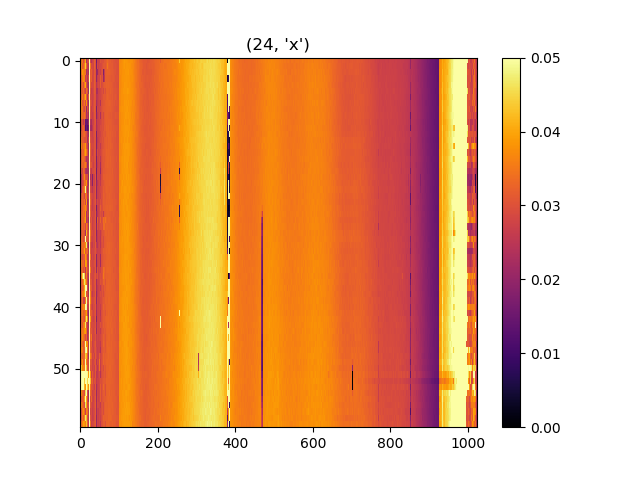

In [3]:
plt.figure()
plt.imshow(np.abs(gains[ant]), cmap='inferno', aspect='auto')
plt.clim([0,.05])
plt.colorbar()
plt.title(ant);

<IPython.core.display.Javascript object>


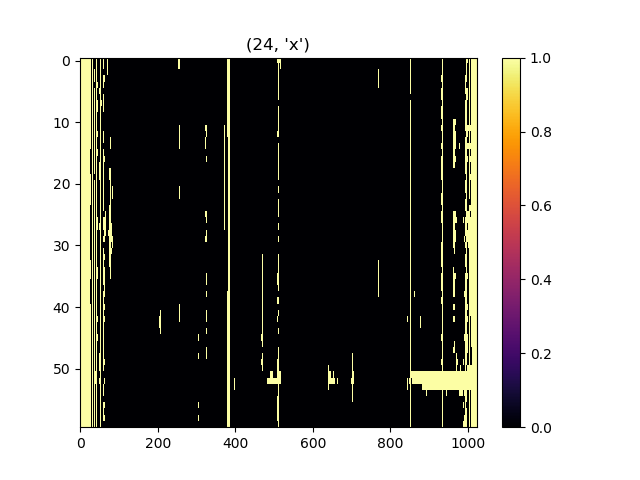

In [4]:
plt.figure()
plt.imshow(flags[ant], cmap='inferno', aspect='auto')
plt.colorbar()
plt.title(ant);

# Build weights

invalid value encountered in divide
divide by zero encountered in power


<IPython.core.display.Javascript object>


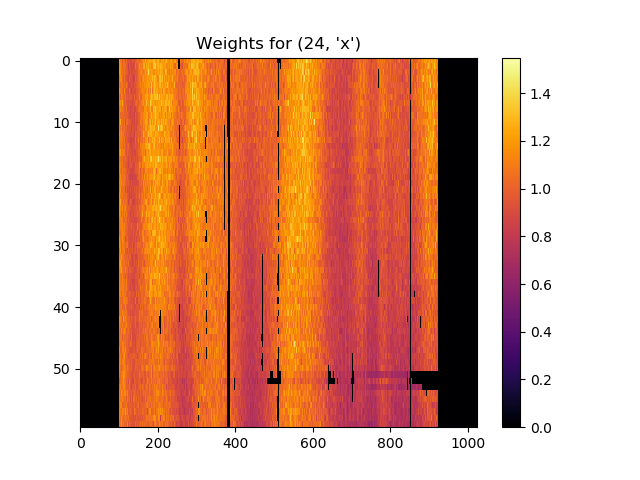

In [5]:
wgts = (quals[ant]/np.abs(data[(ant[0],ant[0],ant[1]+ant[1])])**2)**-.5
wgts[flags[ant]] = 0
wgts[:,0:100] = 0
wgts[:,-100:] = 0
wgts /= np.mean(wgts[wgts>0])
#wgts[wgts>0] = 1
plt.figure()
plt.imshow(wgts, cmap='inferno', aspect='auto')
plt.colorbar()
plt.title('Weights for ' + str(ant));

# Filters

In [6]:
def freq_filter(gains, wgts, freqs, filter_scale = 10.0):
    '''freqs in Hz. filter_scale in MHz.'''
    sdf = np.median(np.diff(freqs)) / 1e9 #in GHz
    filter_size = (filter_scale / 1e3)**-1 #Puts it in ns
    filtered, res, info = uvt.dspec.high_pass_fourier_filter(gains, wgts, filter_size, sdf)
    return filtered

In [7]:
def time_filter(gains, wgts, times, filter_scale = 2):
    '''times in JD. filter_scale in minutes.'''
    if not isinstance(gains, (list,tuple)):
        padded_gains = np.vstack((np.flipud(gains),gains,np.flipud(gains)))
        padded_weights = np.vstack((np.flipud(wgts),wgts,np.flipud(wgts)))
    else:
        raise NotImplementedError('This feature needs to be implemented.')
        #TODO: implement loading previous and subsequent files
    
    nInt, nFreq = gains.shape
    tInt = np.median(np.diff(times))*24*60*60
    kernel_times = np.append(-np.arange(0,nInt*tInt+tInt/2,tInt)[-1:0:-1], np.arange(0,nInt*tInt+tInt/2,tInt))
    kernel = np.exp(-kernel_times**2/2/(filter_scale*60.0)**2)
    kernel /= np.sum(kernel)

    conv_gains = padded_gains * padded_weights**2
    conv_weights = padded_weights**2
    for i in range(nFreq):
        conv_gains[:,i] = scipy.signal.convolve(conv_gains[:,i], kernel, mode='same')
        conv_weights[:,i] = scipy.signal.convolve(conv_weights[:,i], kernel, mode='same')
    conv_gains /= conv_weights
    conv_gains[np.logical_not(np.isfinite(conv_gains))] = 0
    return conv_gains[nInt:2*nInt,:]

In [8]:
freq_filtered = freq_filter(gains[ant], wgts, freqs)
freq_then_time = time_filter(freq_filtered, wgts, times)
time_filtered = time_filter(gains[ant], wgts, times)
time_then_freq = freq_filter(time_filtered, wgts, freqs)

invalid value encountered in divide


In [9]:
freq_then_time_masked = deepcopy(freq_then_time)
freq_then_time_masked[wgts==0] = 0
time_then_freq_masked = deepcopy(time_then_freq)
time_then_freq_masked[wgts==0] = 0

<IPython.core.display.Javascript object>


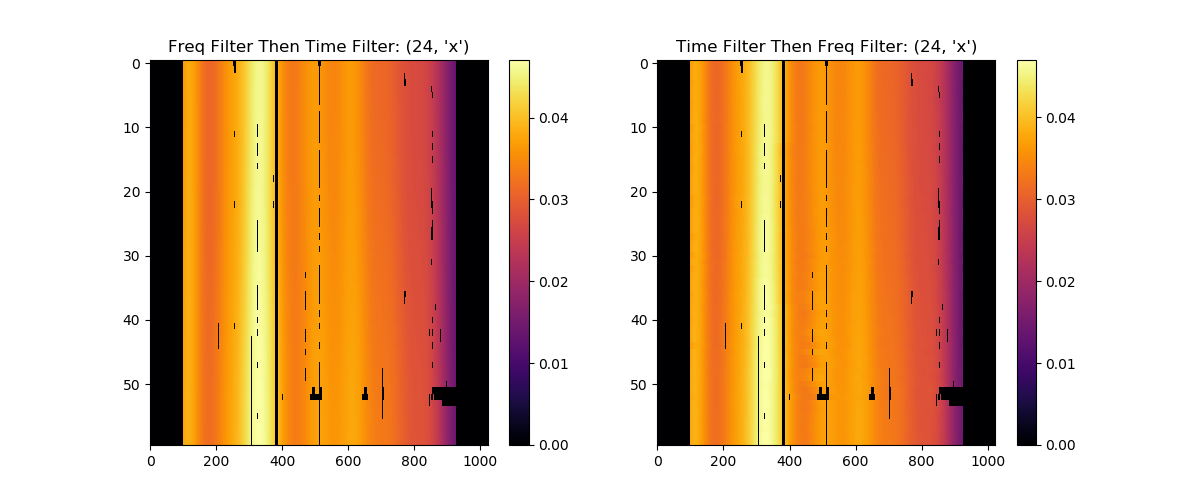

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(np.abs(freq_then_time_masked), cmap='inferno', aspect='auto')
plt.colorbar()
plt.title('Freq Filter Then Time Filter: ' + str(ant));
plt.subplot(122)
plt.imshow(np.abs(time_then_freq_masked), cmap='inferno', aspect='auto')
plt.colorbar()
plt.title('Time Filter Then Freq Filter: ' + str(ant));

<IPython.core.display.Javascript object>


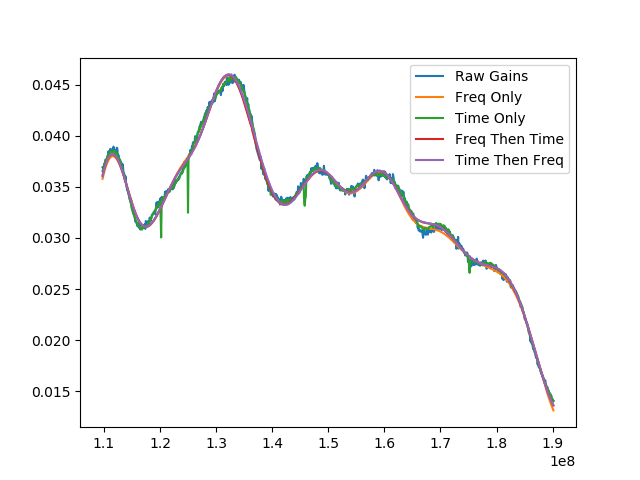

In [11]:
plt.figure()
integration = 10
plt.plot(freqs[wgts[integration,:]>0], np.abs(gains[ant][integration,:][wgts[integration,:]>0]), label='Raw Gains')
plt.plot(freqs[wgts[integration,:]>0], np.abs(freq_filtered[integration,:][wgts[integration,:]>0]), label='Freq Only')
plt.plot(freqs[wgts[integration,:]>0], np.abs(time_filtered[integration,:][wgts[integration,:]>0]), label='Time Only')
plt.plot(freqs[wgts[integration,:]>0], np.abs(freq_then_time_masked[integration,:][wgts[integration,:]>0]), label='Freq Then Time')
plt.plot(freqs[wgts[integration,:]>0], np.abs(time_then_freq_masked[integration,:][wgts[integration,:]>0]), label='Time Then Freq')
plt.legend()

<IPython.core.display.Javascript object>


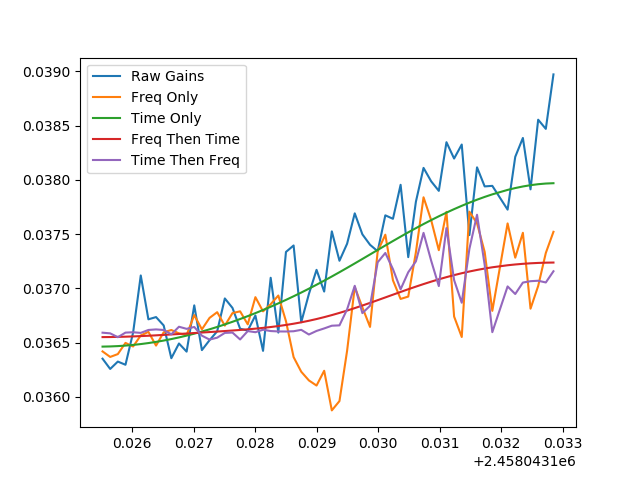

In [12]:
plt.figure()
chan = 500
plt.plot(times[wgts[:,chan]>0], np.abs(gains[ant][:,chan][wgts[:,chan]>0]), label='Raw Gains')
plt.plot(times[wgts[:,chan]>0], np.abs(freq_filtered[:,chan][wgts[:,chan]>0]), label='Freq Only')
plt.plot(times[wgts[:,chan]>0], np.abs(time_filtered[:,chan][wgts[:,chan]>0]), label='Time Only')
plt.plot(times[wgts[:,chan]>0], np.abs(freq_then_time_masked[:,chan][wgts[:,chan]>0]), label='Freq Then Time')
plt.plot(times[wgts[:,chan]>0], np.abs(time_then_freq_masked[:,chan][wgts[:,chan]>0]), label='Time Then Freq')
plt.legend()

In [21]:
def time_filter_2(gains, wgts, times, filter_scale = 2):
    '''times in JD. filter_scale in minutes.'''
    padded_gains = deepcopy(gains)
    padded_weights = deepcopy(wgts)

    nInt, nFreq = gains.shape
    tInt = np.median(np.diff(times))*24*60*60
    kernel_times = np.append(-np.arange(0,nInt*tInt+tInt/2,tInt)[-1:0:-1], np.arange(0,nInt*tInt+tInt/2,tInt))
    kernel = np.exp(-kernel_times**2/2/(filter_scale*60.0)**2)
    kernel /= np.sum(kernel)

    conv_gains = padded_gains * padded_weights**2
    conv_weights = padded_weights**2
    for i in range(nFreq):
        conv_gains[:,i] = scipy.signal.convolve(conv_gains[:,i], kernel, mode='same')
        conv_weights[:,i] = scipy.signal.convolve(conv_weights[:,i], kernel, mode='same')
    conv_gains /= conv_weights
    conv_gains[np.logical_not(np.isfinite(conv_gains))] = 0
    return conv_gains

time_filtered1 = time_filter(gains[ant], wgts, times)
time_filtered2 = time_filter_2(gains[ant], wgts, times)

invalid value encountered in divide
invalid value encountered in divide


<IPython.core.display.Javascript object>


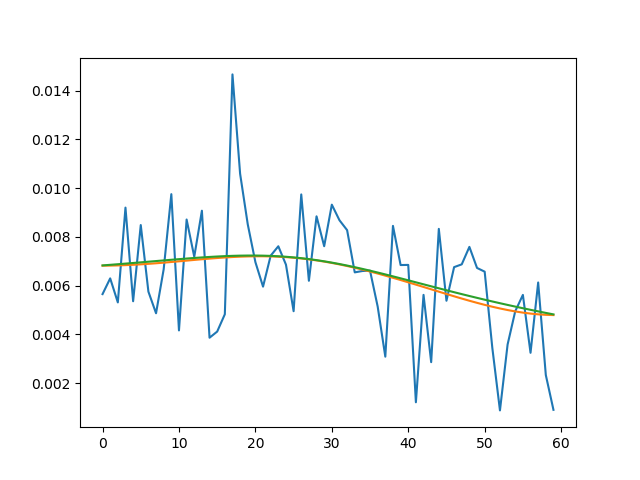

In [22]:
chan = 800
plt.figure()
plt.plot(gains[ant][:,chan])
plt.plot(time_filtered1[:,chan])
plt.plot(time_filtered2[:,chan],'-')

In [17]:
time_filtered2

array([], shape=(0, 1024), dtype=complex64)

In [24]:
np.exp(-np.linspace(-10,10,.1)**2)

object of type <type 'float'> cannot be safely interpreted as an integer.


array([], dtype=float64)